In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import os
import data_utils
import rasterio
import matplotlib.pyplot as plt

# Interact
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import bqplot.pyplot as bqp
from ipywidgets import VBox, HBox, IntSlider, Button, Output

In [3]:
# Altering functions:

def apply_gamma_correction(image, gamma):
    # Normalize the image to [0, 1]
    image_float = image / 255.0
    # Apply gamma correction
    corrected_image = np.power(image_float, gamma)
    # Scale back to [0, 255] and convert to 8-bit
    corrected_image = np.clip(corrected_image * 255, 0, 255).astype(np.uint8)
    return corrected_image

def adjust_brightness(image, brightness_factor):
    adjusted_image = image + brightness_factor
    adjusted_image = np.clip(adjusted_image, 0, 255).astype(np.uint8)
    return adjusted_image

def adjust_contrast(image, contrast_factor):
    # Calculate the mean of the image for contrast adjustment
    mean = np.mean(image)
    adjusted_image = (image - mean) * contrast_factor + mean
    adjusted_image = np.clip(adjusted_image, 0, 255).astype(np.uint8)
    return adjusted_image

def histogram_stretching(image):
    # Convert to float to avoid issues during division
    img = image.astype('float')
    
    # Get minimum and maximum pixel values
    min_val = np.min(img)
    max_val = np.max(img)
    
    # Apply histogram stretching
    stretched_img = (img - min_val) / (max_val - min_val) * 255.0
    
    return stretched_img.astype('uint8')



In [4]:
# Prepare UI for picking region and asking user to select 


# Path to the datasets:
path_to_master_folder = '/Users/vihaan/Workspace/!Datasets/Test_Data'
all_region_images = path_to_master_folder + '/Image'

# print all the regions
print(os.listdir(all_region_images))

# Dropdown menu options with region names
region_options = {}

# Add region names to the region option dict
for region in os.listdir(all_region_images):
    region_options[region] = region

# Global variable (Current region we are tackling)
current_region = None

# Dropdown menu for selecting region
region_dropdown = widgets.Dropdown(
    options=region_options,
    description='Region:',
    disabled=False,
)

# Function to handle region selection
def on_region_change(change):
    global current_region
    if change['type'] == 'change' and change['name'] == 'value':
        current_region = change['new']
        print('Selected region:', current_region)

# Attach the function to the dropdown menu
region_dropdown.observe(on_region_change, names='value')

# Display the dropdown menu
display(region_dropdown)

['1998 Jueili', '.DS_Store', '1991 Limon Earthquake', '1999 chamoli earthquake', '1999 chichi earthquake']


Dropdown(description='Region:', options={'1998 Jueili': '1998 Jueili', '.DS_Store': '.DS_Store', '1991 Limon E…

Selected region: 1991 Limon Earthquake


In [5]:
# printing the current region as a check
print('Current region:', current_region)

# Once the region is picked, we list all the area patch names in the region for reference and prepare a similar dropdown menu for area patch selection
area_list = os.listdir(all_region_images + '/' + current_region)

# Dropdown menu options with area patch names
area_options = {}

# Add area patch names to the area option dict
for area in area_list:
    area_options[area] = area

# Global variable (Current area we are tackling)
current_area = None

# Dropdown menu for selecting area patch
area_dropdown = widgets.Dropdown(
    options=area_options,
    description='Area:',
    disabled=False,
)

# Function to handle area patch selection
def on_area_change(change):
    global current_area
    if change['type'] == 'change' and change['name'] == 'value':
        current_area = change['new']
        print('Selected area:', current_area)

# Attach the function to the dropdown menu
area_dropdown.observe(on_area_change, names='value')

# Display the dropdown menu
display(area_dropdown)



Current region: 1991 Limon Earthquake


Dropdown(description='Area:', options={'.DS_Store': '.DS_Store', 'LT05_L2SP_014053_19920303_20200914_02_T2': '…

Selected area: LT05_L2SP_014053_19920303_20200914_02_T2


Current area: LT05_L2SP_014053_19920303_20200914_02_T2


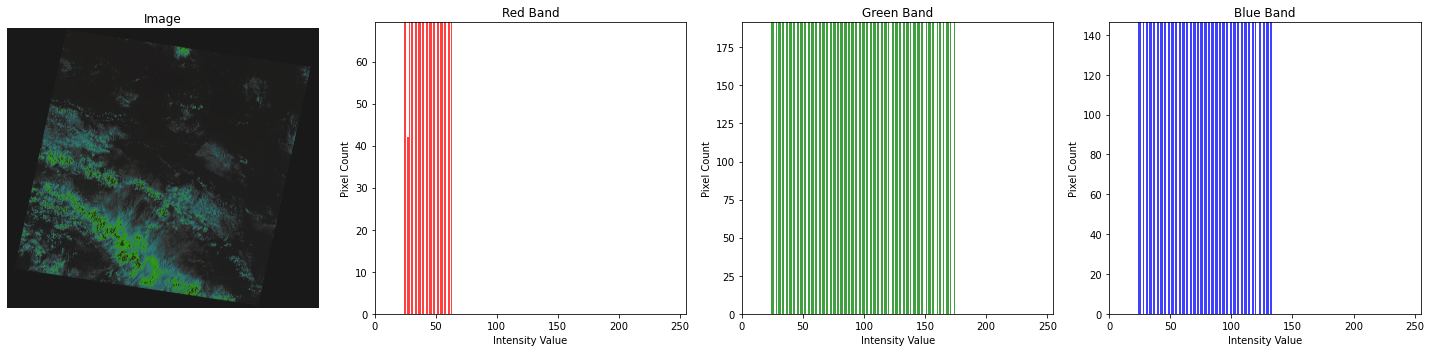

In [7]:
# Checking if the current region was selected correctly
print('Current area:', current_area)

# Currently we've selected the region and area patch. Now we list all the images in the area patch for reference and prepare a similar dropdown menu for image selection
area_folder_path = all_region_images + '/' + current_region + '/' + current_area

# Make a list of all bands in the area folder
band_files = []

# Get bands we want to use: (ideallly B1, B2 and B3)
desired_bands = ['B1.TIF', 'B2.TIF', 'B3.TIF']
band_numbers = [1,2,3]   # Also update band numbers when you update desired bands
# TODO: Write a check here?

# Obtain names of the bands:
for files in os.listdir(area_folder_path):

    if files[-6:] in desired_bands:
        band_files.append(files)

band_files = sorted(band_files)

# Function to display image after selection
def print_selected_area(area_folder_path, band_files, band_numbers):
    # Load the bands and obtain the band numpy values:
    combined_numpy_array = data_utils.combine_bands_to_single_tif(bands_folder = area_folder_path, band_files = band_files, band_numbers = band_numbers, output_file = '.', save = False)

    # Reshaping to match dimension
    img_reshaped = np.transpose(combined_numpy_array, (1, 2, 0))

    # Normalising the image:
    numpy_image = img_reshaped
    if numpy_image.dtype == np.uint16:
        scale_factor = 65535 // 255
        numpy_image = (numpy_image / scale_factor).astype(np.uint8)
    elif numpy_image.max() <= 1:  # float images in [0, 1] range
        numpy_image = (numpy_image * 255).astype(np.uint8)


    # Display the image
    plt.imshow(numpy_image)
    plt.show()

#print_selected_area(area_folder_path, band_files, band_numbers)


# Function to display image after selection
def print_selected_area_with_color_curves(area_folder_path, band_files, band_numbers):
    # Load the bands and obtain the band numpy values:
    combined_numpy_array = data_utils.combine_bands_to_single_tif(bands_folder = area_folder_path, band_files = band_files, band_numbers = band_numbers, output_file = '.', save = False)

    # Reshaping to match dimension
    img_reshaped = np.transpose(combined_numpy_array, (1, 2, 0))

    # Normalising the image:
    if img_reshaped.dtype == np.uint16:
        scale_factor = 65535 // 255
        img_reshaped = (img_reshaped / scale_factor).astype(np.uint8)
    elif numpy_image.max() <= 1:  # float images in [0, 1] range
        img_reshaped = (img_reshaped* 255).astype(np.uint8)

    ########### Apply filters as you wish #########
    img_processed = img_reshaped
    # Apply gamma correction with a gamma of 2.2 as an example
    img_processed = apply_gamma_correction(img_processed, 2.2)
    # Adjust brightness with a factor of 30 as an example
    img_processed= adjust_brightness(img_processed, 30)
    # Adjust contrast with a factor of 1.5 as an example
    img_processed = adjust_contrast(img_processed, 1.5)

    # final_image after all processing:
    numpy_image = img_processed

    # Prepare a histogram for each band & display it along with the image
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # One for the image and three for histograms
    axs[0].imshow(numpy_image)
    axs[0].set_title('Image')
    axs[0].axis('off')  # Optional: turn off axis for the image plot

    # Colors for each histogram corresponding to the RGB channels
    colors = ['red', 'green', 'blue']
    channel_names = ['Red Band', 'Green Band', 'Blue Band']

    for i in range(3):
        axs[i + 1].hist(numpy_image[:, :, i].ravel(), bins=256, range=(0, 255), color=colors[i], alpha=0.75)
        axs[i + 1].set_title(channel_names[i])
        axs[i + 1].set_xlim([0, 255])  # Optional: limit x-axis for clarity
        axs[i + 1].set_ylim([0, numpy_image[:, :, i].ravel().max() * 1.1])  # Slightly increase y-axis limit for visual appeal
        axs[i + 1].set_xlabel('Intensity Value')
        axs[i + 1].set_ylabel('Pixel Count')

    plt.tight_layout()  # Adjust layout to make sure everything fits without overlap
    plt.show()

    return numpy_image

final_image = print_selected_area_with_color_curves(area_folder_path, band_files, band_numbers)


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# Sample image for demonstration
numpy_image = final_image

coefficients = {
    'Red': {'a': 0, 'b': 0, 'c': 1, 'd': 0},
    'Green': {'a': 0, 'b': 0, 'c': 1, 'd': 0},
    'Blue': {'a': 0, 'b': 0, 'c': 1, 'd': 0}
}

curve_output = widgets.Output()
image_output = widgets.Output()

def update_curves_and_image():
    with curve_output:
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(10, 5))
        x = np.linspace(0, 255, 256)
        colors = {'Red': 'red', 'Green': 'green', 'Blue': 'blue'}
        for color in colors:
            coeffs = coefficients[color]
            y = np.polyval([coeffs['a'], coeffs['b'], coeffs['c'], coeffs['d']], x)
            ax.plot(x, y, label=f'{color} curve', color=colors[color])
        ax.plot(x, x, 'k--', label='Identity line')
        ax.set_title('Color Curves')
        ax.set_xlim([0, 255])
        ax.set_ylim([0, 255])
        ax.legend()
        ax.grid(True)
        plt.show()

    with image_output:
        clear_output(wait=True)
        adjusted_image = numpy_image.copy()
        for color, idx in zip(['Red', 'Green', 'Blue'], range(3)):
            coeffs = coefficients[color]
            curve = np.polyval([coeffs['a'], coeffs['b'], coeffs['c'], coeffs['d']], x)
            adjusted_image[:, :, idx] = np.clip(np.interp(numpy_image[:, :, idx], x, curve), 0, 255).astype(np.uint8)
        plt.figure(figsize=(5, 5))
        plt.imshow(adjusted_image)
        plt.axis('off')
        plt.show()

# Create sliders and their value displays
sliders = {}
value_displays = {}
for color in ['Red', 'Green', 'Blue']:
    for coeff in ['a', 'b', 'c', 'd']:
        min_val = -0.0005 if coeff in ['a', 'b'] else -10
        max_val = 0.0005 if coeff in ['a', 'b'] else 10
        step_val = 0.00001 if coeff in ['a', 'b'] else 1
        sliders[f'{color}_{coeff}'] = widgets.FloatSlider(
            value=coefficients[color][coeff],
            min=min_val,
            max=max_val,
            step=step_val,
            description=f'{color} {coeff}:',
            continuous_update=False,
            readout_format='.5f'  # More precise format
        )
        # Create FloatText to display values with high precision
        value_displays[f'{color}_{coeff}'] = widgets.FloatText(description=f'Current {color} {coeff}:')
        widgets.jslink((sliders[f'{color}_{coeff}'], 'value'), (value_displays[f'{color}_{coeff}'], 'value'))

        sliders[f'{color}_{coeff}'].observe(lambda change, color=color, coeff=coeff: on_slider_change(change, color, coeff), names='value')

def on_slider_change(change, color, coeff):
    coefficients[color][coeff] = change.new
    update_curves_and_image()

# Organize sliders and value displays into a UI
ui = widgets.VBox([
    widgets.HBox([widgets.VBox([widgets.HBox([sliders[f'{color}_{coeff}'], value_displays[f'{color}_{coeff}']]) for coeff in ['a', 'b', 'c', 'd']]) for color in ['Red', 'Green', 'Blue']])
])
display(ui, curve_output, image_output)
update_curves_and_image()


Output()

Output()

# Checking YOLO vizualisation:

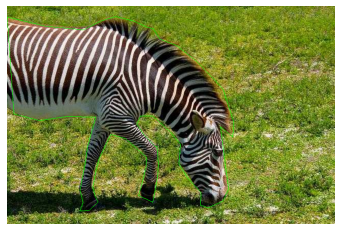

In [16]:
# pick a random image and corresponding label from the YOLO dataset:
image_directory = yolo_example_dataset + '/images' + '/train'
label_directory = yolo_example_dataset + '/labels' + '/train'

# Choosing a random image path from this directory:
image_path = image_directory + '/' + numpy.random.choice(os.listdir(image_directory))

# Choosing the corresponding label for the image above from the label directory by matching the name
label_path = label_directory + '/' + os.path.basename(image_path).split('.')[0] + '.txt'


# printing an image from YOLO format with labels:
data_utils.print_yolo_labels_on_image_jupyter_notebook(image_path = image_path, yolo_label_format = label_path)


# Checking COCO format vizualisation:

# Checking S24 dataset

In [8]:
# Dataset Paths

# yolo label folders:
train_yolo_labels = '../RCNN_Experiment_S24/train_yolo_labels_S24'
val_yolo_labels = '../RCNN_Experiment_S24/val_yolo_labels_S24'
test_yolo_labels = '../RCNN_Experiment_S24/test_yolo_labels_S24'

# Target npy folders:
train_numpy_images = '../RCNN_Experiment_S24/train_numpy_images_S24'
val_numpy_images = '../RCNN_Experiment_S24/val_numpy_images_S24'
test_numpy_images = '../RCNN_Experiment_S24/test_numpy_images_S24'

In [31]:
# Obtaining an image from train and the corresponding label
image_path = train_numpy_images + '/' + np.random.choice(os.listdir(train_numpy_images))

print(image_path)

# Check if it is a npy extension, then read as a numpy file
if image_path[-3:] == 'npy':
    image_numpy = np.load(image_path)

print(image_numpy.shape)

# Taking only the first three bands:
image_numpy_rgb = image_numpy[0:3,:,:]

print(image_numpy_rgb.shape)

../RCNN_Experiment_S24/train_numpy_images_S24/1987 Sichuan pre-earthquake_patch_3808_9184.npy
(6, 224, 224)
(3, 224, 224)


../RCNN_Experiment_S24/train_yolo_labels_S24/1987 Sichuan pre-earthquake_patch_3808_11872.txt


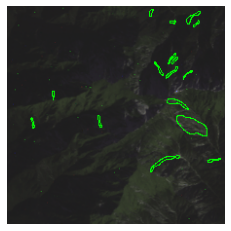

In [106]:
# Obtaining an image from train and the corresponding label
image_name = np.random.choice(os.listdir(train_numpy_images))
numpy_image_path = train_numpy_images + '/' + image_name

yolo_label_format = train_yolo_labels + '/' + image_name[:-3] + 'txt'
print(label_path)

data_utils.print_yolo_labels_on_numpy_image_jupyter_notebook(numpy_image_path, yolo_label_format)

# Check labels on image (jpeg) directly:



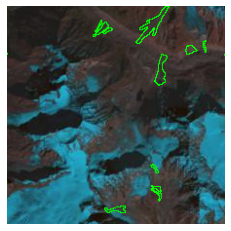

In [44]:
train_target_folder = '../RCNN_Experiment_S24/train_images_S24'
test_target_folder = '../RCNN_Experiment_S24/test_images_S24'
val_target_folder = '../RCNN_Experiment_S24/val_images_S24'

train_yolo_labels = '../RCNN_Experiment_S24/train_yolo_labels_S24'
val_yolo_labels = '../RCNN_Experiment_S24/val_yolo_labels_S24'
test_yolo_labels = '../RCNN_Experiment_S24/test_yolo_labels_S24'


# Get list of images in the train folder:
train_images = os.listdir(train_target_folder)
random_image = np.random.choice(train_images)

image_path = train_target_folder + '/' + random_image
yolo_label_format = train_yolo_labels + '/' + random_image[:-4] + 'txt'

data_utils.print_yolo_labels_on_image_instance_segmentation_jupyter_notebook(image_path, yolo_label_format)

